In [216]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import torch, urllib
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import torch.nn.functional as F
import torch.nn as nn
import torch.fft as fft

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/drunet/pytorch/default/1/drunet.py


## Hypothèses

- image avec du bruit corrélé
- le kernel suit un padding circulaire

## Démarche

Une image avec du bruit corrélé peut être définie comme (équation 8 de l'article plug and play) :

$$
y = x + k \otimes n, \quad n \sim \mathcal{N}(0, I)
$$

avec :
-  y : l’imae bruitée
-  x : l’image originale (non bruitée)
-  k : le noyau de convolution
-  n : bruit blanc gaussien

---

## Étape "data term"

Dans le schéma ADMM / HQS, on doit résoudre (équation 6a du papier) :
A la différence de l'équation dans plug and play, T(x) = Kx car ici Kx est la transformation que l'on applique à l'image (application de bruit corrélé)

$$
x^{(t+1)} 
= \arg\min_{x}\;
\frac{1}{2}\,(y - x)^{\top} (K K^{\top})^{-1} (y - x)
\;+\; \lambda\, R\!\left(z\right)
\;+\; \frac{\alpha}{2}\,\| x - z^{(t)} \|_2^{\,2}.
\tag{1}
$$


où :
- K  est l’opérateur de convolution associé à \( k \),
-  z(t) vient de l’étape de prior (denoiser),
- alpha > 0  est un paramètre de pénalisation (que l'on peut fine tuner ?)

la premiere partie de l'équation assure que l'on reste proche de l'image d'origine, la seconde partie force x à rester proche de la version non bruitée de l'étape précédente z(t).
la premiere partie et la seconde partie de l'équation sont séparées et traiter séparement et itérativement dans la boucle data_step.

En dérivant l'expression précédente par rapport à x on a:
$$
\nabla_x = (K K^{\top})^{-1}(x - y) + \alpha\,(x - z^{(t)}).
$$

---

## Passage dans le domaine de Fourier

Pourquoi on passe dans le domaine de fourier ? 
sans Fourier : il faudrait différencier (1) par rapport à X et pour trouver la close forme solution inverser K.T @ K+ρI ce qui est coûteux
avec Fourier : on a une division par un scalaire en chaque fréquence, donc bcp + rapide.


Règle de Fourier : si K est une convolution (de taille m << n) x vecteur de taille n on a :

$$
\mathcal{F}(Kx) = \mathcal{F} (k) \cdot \mathcal{F} (x)
$$

donc : 

$$
x \;=\; \mathcal{F}^{-1}\!\left( \frac{\mathcal{F}(y)}{\mathcal{F}(k)} \right).
$$


Si on fixe le gradient de x par rapport à 0 et qu'on isole x on se retrouve avec : 

$$
\bigl(I + \alpha\, K K^{\top}\bigr)\, x
\;=\;
y \;+\; \alpha\, K K^{\top} z.
$$

donc en notant : 
$$
K' = \bigl(I + \alpha\, K K^{\top}\bigr)\
$$

En utilisant les règles de Fourier : 

$$
x \;=\; 
\mathcal{F}^{-1}\!\left(
    \frac{\mathcal{F}\!\bigl(y + \alpha\, K K^{\top} z\bigr)}
         {\mathcal{F}(k')}
\right).
$$

---

## Étape "prior"

On applique ensuite un débruiteur digne de ce nom comme Drunet :

$$
z^{(t+1)} = D_\theta \big( x^{(t+1)} \big)
$$

---

## Boucle Plug-and-Play

Puis on itère K fois avec en premier résolution de l'équation (1) puis denoiser :

1. **Data step (Fourier)** :
  $$
x^{(t+1)} 
= \arg\min_{x}\;
\frac{1}{2}\,(y - x)^{\top} (K K^{\top})^{-1} (y - x)
\;+\; \lambda\, R\!\left(z\right)
\;+\; \frac{\alpha}{2}\,\| x - z^{(t)} \|_2^{\,2}.
\tag{1}
$$

2. **Prior step (denoiser)** :
   $$
   z^{(t+1)} = D_\theta(x^{(t+1)})
   $$

3. et on répète


vérif avec matrice + padding que f(kxy) = f(k)xf(y) !!!!!!!!!!!!!!!

### Creating an image with correlated noise

In [217]:
url = "https://boofcv.org/images/f/fe/Original_lena512.jpg"
image = Image.open(urllib.request.urlopen(url))
img_gray = image.convert("L")
image_np = np.array(img_gray)
image_torch = torch.from_numpy(image_np).float()

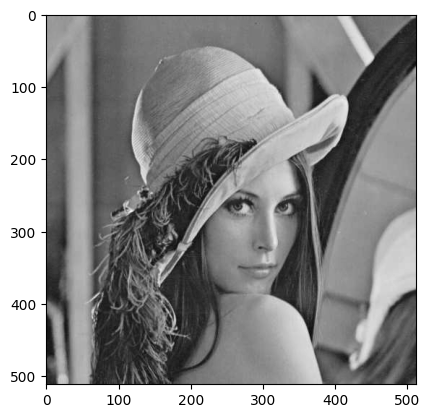

In [218]:
plt.imshow(image_torch, cmap="gray")

In [219]:
H, W = image_torch.shape[0], image_torch.shape[1]   

# Générer bruit blanc
sigma = 40.0
noise_white = torch.randn(1,1,H,W) * sigma 

# noyau
def gaussian_kernel(size=3, sigma=1.0):
    ax = torch.arange(-size // 2 + 1., size // 2 + 1.)
    xx, yy = torch.meshgrid(ax, ax, indexing="ij")
    kernel = torch.exp(-(xx**2 + yy**2) / (2. * sigma**2))
    kernel = kernel / kernel.sum()
    return kernel

k = gaussian_kernel(size=3, sigma=1.0)         
k = k.unsqueeze(0).unsqueeze(0)                 

# convolution circulaire
noise_white_padded = F.pad(noise_white, (1, 1, 1, 1), mode="circular")  
noise_corr = F.conv2d(noise_white_padded, k, padding=0)



image_noised = image_torch + noise_corr


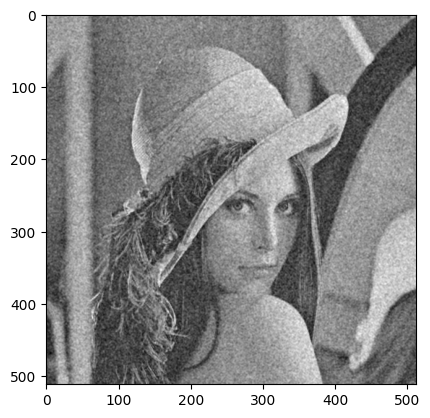

In [220]:
plt.imshow(image_noised[0][0],  cmap="gray")

### basic methods with basic examples

In [221]:
matrix = [[1,2,3], [4,5,6], [7,8,9]]
matrix = torch.from_numpy(np.array(matrix)) # conversin en tensor

#reshape
matrix = matrix.reshape(1, 1, matrix.shape[0], matrix.shape[1]).float()

print(matrix)
print(matrix.shape)
k = gaussian_kernel(size=3, sigma=1.0)         
k = k.unsqueeze(0).unsqueeze(0)   

tensor([[[[1., 2., 3.],
          [4., 5., 6.],
          [7., 8., 9.]]]])
torch.Size([1, 1, 3, 3])


In [222]:
# prend un tensor d'une certaine taille et une convolution. et on applique cette convolution sur l'image paddée (ici circulaire)
# pq le padding ? si pas de padding mon image de sortie n'aura pas la même dimension que mon image d'entrée
# pq circulaire ? car on veut que la convolution soit équivalente à une multiplication dans le domaine de fourier.
# et on prend un kenel gaussien car on veut un bruit corrélé spatialement.
def conv(matrix, k):
    matrix_padded = F.pad(matrix, (1, 1, 1, 1), mode="circular")  
    print(matrix_padded)
    matrix_conv = F.conv2d(matrix_padded, k, padding=0)
    return matrix_conv







In [223]:
matrix

tensor([[[[1., 2., 3.],
          [4., 5., 6.],
          [7., 8., 9.]]]])

In [224]:
kmatrix = conv(matrix, k)
kmatrix

tensor([[[[9., 7., 8., 9., 7.],
          [3., 1., 2., 3., 1.],
          [6., 4., 5., 6., 4.],
          [9., 7., 8., 9., 7.],
          [3., 1., 2., 3., 1.]]]])


tensor([[[[4.2888, 4.4666, 4.6444],
          [4.8222, 5.0000, 5.1778],
          [5.3556, 5.5334, 5.7112]]]])

verif que F(kmatrix) = F(k) * F(matrix)

In [225]:
a = torch.fft.fft2(kmatrix)

In [226]:
b = torch.fft.fft2(k) * torch.fft.fft2(matrix)

In [227]:
a

tensor([[[[ 4.5000e+01+0.0000e+00j, -8.0007e-01+4.6192e-01j,
           -8.0007e-01-4.6192e-01j],
          [-2.4002e+00+1.3858e+00j, -4.8425e-07-4.1295e-07j,
            9.6109e-07-4.1295e-07j],
          [-2.4002e+00-1.3858e+00j,  9.6109e-07+4.1295e-07j,
           -4.8425e-07+4.1295e-07j]]]])

In [228]:
b

tensor([[[[45.0000+0.0000j,  0.8001+0.4619j,  0.8001-0.4619j],
          [ 2.4002+1.3858j, -0.0000+0.0000j,  0.0000+0.0000j],
          [ 2.4002-1.3858j,  0.0000+0.0000j,  0.0000-0.0000j]]]])

In [229]:
a[0][0][2]

tensor([-2.4002e+00-1.3858e+00j,  9.6109e-07+4.1295e-07j,
        -4.8425e-07+4.1295e-07j])

In [230]:
b[0][0][2]

tensor([2.4002-1.3858j, 0.0000+0.0000j, 0.0000-0.0000j])

In [231]:
# calcul de la convolution k'
# K = K.T


def compute_k_prime(k, alpha):
    # k: tensor shape (1,1,h,w)
    _, _, h, w = k.shape
    
    # 1) Convolution de k avec lui-même (k ⊗ k)
    # convolution circulaire comme avant
    k_padded = F.pad(k, (w//2, w//2, h//2, h//2), mode="circular")
    k_corr = F.conv2d(k_padded, k, padding=0)   # taille (1,1,h,w)
    
    # 2) Noyau identité (1 au centre, 0 ailleurs)
    delta = torch.zeros_like(k)
    delta[..., h//2, w//2] = 1.0
    
    # 3) k' = δ + α (k ⊗ k)
    k_prime = delta + alpha * k_corr
    return k_prime

In [232]:
alpha = 0.3
conv(matrix,compute_k_prime(k, alpha))

tensor([[[[9., 7., 8., 9., 7.],
          [3., 1., 2., 3., 1.],
          [6., 4., 5., 6., 4.],
          [9., 7., 8., 9., 7.],
          [3., 1., 2., 3., 1.]]]])


tensor([[[[ 2.4621,  3.4716,  4.4810],
          [ 5.4905,  6.5000,  7.5095],
          [ 8.5190,  9.5285, 10.5379]]]])

In [233]:
def solve_step_1(alpha, k, y, z):
    num_before_fourier = y + alpha @ k @ k.T @ z
    num = torch.fft.fft2(num_before_fourier)

    denom_before_fourier = conv(matrix,compute_k_prime(k, alpha))

    denom = torch.fft.fft2(denom_before_fourier)

    x_t_1 = torch.fft.ifft2(num/denom)
    
    return x_t_1

In [234]:
def solve_step_2(denoiser, x, sigma):
    return denoiser(x, sigma)



liste des params : 

K : nombres d'itérations. dans le papier 8, 24 ou 40
lambda : regularization params, il régularise quoi déjà ?. fixé à 0.23, apparemment bonne perf entre 0.19 et 0.55 . the role of controlling the trade-off between data term and prior term. ça veut dire quoi ???

sigma_k : au fur et à mesure qu'on avance, l'image se débruite donc on recalcule ce niveau de bruit à chaque itération pour que dans le denoiser on indique le bon niveau de bruit
            valeurs : on commence au niveau de bruit de l'image et on finit à 1, décroissance exponentielle
            
alpha_k : l'interprétation de alpha_k ??? : αk = λσ2/σ2k



In [235]:
# params
K = 24 # le nombre d'itération, regarder dans le papier
big_k = 40
small_k = 1
lbda = 0.23
# alpha_k = lambda/(sigma_k**2)


sigmas = np.logspace(np.log10(big_k), np.log10(small_k), K)

alphas = [lbda * big_k**2/(sigmas[idx]**2) for idx in range(len(sigmas))]

In [236]:
# aggegation du step1 et du step2

for t in range(K):
    #params
    sigma_t = sigmas[t]
    alpha_t = alphas[t]

    x_t = solve_step_1(alpha_t, k, y, z_t)
    z_t = solve_step_2(denoiser, x_t, sigma_t)

NameError: name 'y' is not defined

to di *


def solve_step_1(alpha, k, y, z) : 

    num = y + conv(conv(z, k), k)

    denom = kernel2_image(k', taille_image)

    return = f⁻1 (f(num)/f(denm))




    écrire la fonction conv, la fonction kenel2 image et solve_step1 et step2 et vérifier que f(kxy) = f(k) * f(y)

# Avant

In [ ]:
#proxy of drunet for lighter model for now
#padding de 1 pour le moment pour que l'image de sortie soit de même dimension que l'input mais on pourra faire évoluer ça
#class SimpleDenoiser(nn.Module):
#    #channels =1 c'est parce qu'on veut des images en noir et blanc, si RGB mettre 3
#    def __init__(self, channels=1):
#        super().__init__()
#        self.net = nn.Sequential(nn.Conv2d(channels, 64, 3, padding=1),
#                    nn.ReLU(),
#                    nn.Conv2d(64, channels, 3, padding=1)
#                                )
#    def forward(self, x):
#        return self.net(x)

# === GPU CONFIGURATION ===
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")


import sys
sys.path.append("/kaggle/input/drunet/pytorch/default/1")

from drunet import DRUNet

# Exemple d’utilisation :


# Plug-and-Play Unrolled Net
class PnPUnrolled(nn.Module):
    def __init__(self, kernel, K=5, sigma=0.01):
        super().__init__()
        self.K = K           # nombre d'itérations/unrolled blocks
        self.sigma = sigma
        self.denoiser = DRUNet().to(device)

        # Fourier transform, we assume circular convolution, is it the case ?
        self.kernel = kernel
        pad = (512 - kernel.shape[0], 512 - kernel.shape[1])
        k_padded = F.pad(kernel, (0, pad[1], 0, pad[0]))
        self.Hf = fft.fft2(k_padded)  # FFT du noyau

    def data_step(self, y, z, rho):
    
        Y = torch.fft.fft2(y)
        Z = torch.fft.fft2(z)
    
        H = self.Hf  # doit être un tensor torch, même device que y
        noise_white_padded = F.pad(noise_white, (1, 1, 1, 1), mode="circular")  
        num = Y + rho * F.conv2d(noise_white_padded, self.kernel)              # pas de conjugué icic !!!!!!!!!!!!!!!!!!!
        denom = 1 + rho * ((H)**2)                  
    
        x = torch.fft.ifft2(num / denom).real
        
        return x


    def forward(self, y):
        # init
        x = y.clone()
        z = y.clone()
        rho = 1.0
        sigma_ks ="exp(ln(linspace(1, 49, K, reverse))"

        for i in range(self.K):
            #Data step
            x = self.data_step(y, z, rho)

            #rajout de cette ligne sinon importante perte de contraste dans l'image (tout en gris avec très peu de nuances)
            #x = torch.clamp(x, 0, 255)

            # Prior step (denoiser appliqué sur x)
            lbda = 0.23 # In this paper, we fix it to 0.23 unless otherwise specified
            sigma_k = sigma_ks[i]
            alpha_k = lbda/(sigma_k **2)
            sigma_norm = (lbda / sigma) ** (1/2)
            sigma_map = torch.full_like(x[:, :1, :, :], sigma_norm)
            input_drunet = torch.cat([x, sigma_map], dim=1)
            z = self.denoiser(x)
            

        return x


### test

In [ ]:
# Exemple d'essai avec différents K
# K = nombre d'itérations (data step + prior step)
# On utilise .half() pour réduire la mémoire GPU

kernel = gaussian_kernel(size=3, sigma=1.0).to(device)

for K in range(1, 40, 1):
    
    model = PnPUnrolled(kernel, K=K).to(device)
    
    # Désactivation de l'entraînement du débruiteur
    for p in model.denoiser.parameters():
        p.requires_grad = False

    image_noised = image_noised.to(device)
    
    # Pas de gradients pendant l'inférence
    with torch.no_grad():
        out = model(image_noised)
    
    # Affichage
    plt.imshow(out.detach().cpu().numpy()[0][0], cmap="gray")
    plt.title(f"K = {K}")
    plt.show()

    # Libération explicite de la mémoire GPU à chaque itération
    torch.cuda.empty_cache()


In [ ]:
# grand impact de sigma

kernel = gaussian_kernel(size=3, sigma=1.0).to(device)

for sigma in np.logspace(-2, 2.3, num=10):
    model = PnPUnrolled(kernel, K=3, sigma = sigma).to(device)
    out = model(image_noised)
    plt.imshow(out.detach().cpu().numpy()[0][0],  cmap="gray")
    plt.show()